In [1]:
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import integrate
import numpy as np

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6
r0=np.sqrt(x0**2 + y0**2 + z0**2)

Mbar=2.*10**10 #Msun

def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar(z,y,x):
    return np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x))



def rfun(x,y):
    return z0*np.sqrt(1 - (x/x0)**2 - (y/y0)**2)

def qfun(x,y):
    return 0.

def hfun(x):
    return y0*np.sqrt(1-(x/x0)**2.)

def gfun(x):
    return 0.

#the density form has the symmetry under x --> -x , y --> -y, z--> -z 

norm= 8.*integrate.tplquad(rho_bar,0.,x0,gfun,hfun,qfun,rfun)[0]

print norm

rho0=Mbar/norm

def rho_bar_norm(z,y,x):
    return rho0*rho_bar(z,y,x)



1.97172574279


In [3]:
print rho_bar_norm(1,2,3)

2087967.45233


/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in power



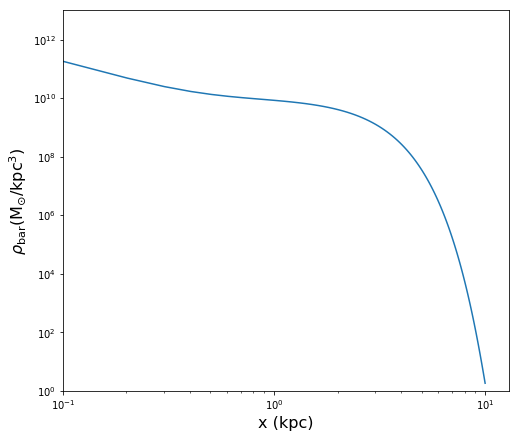

In [4]:
xx=np.linspace(0.,10.,100)
yy=np.zeros(100)
zz=np.zeros(100)

plt.figure(figsize=(8,7))
plt.loglog(xx,rho_bar_norm(zz,yy,xx))
plt.ylim(1.,10**13.)
plt.xlim(0.1,13.)
plt.ylabel(r'$\rho_{\rm{bar}} (\rm{M}_{\odot}/\rm{kpc}^{3})$ ',fontsize=16)
plt.xlabel(r'x (kpc)',fontsize=16)
plt.show()

In [13]:
#define function for the bar density, using form from Dwek (1995) as of now
# transformed from cartesian to cylindrical for galpy

def r1c(R,z,p):
    return ((R**4.)*(np.sin(p)**2./x0**2 + np.cos(p)**2/y0**2)**2 + (z/z0)**4.)**(0.25)

def r2c(R,z):
    return np.sqrt((q*R)**2. + z**2.)/z0


def rho_bar_cyl(R,z,p):
    return np.exp(-r1c(R,z,p)**2./2.) + r2c(R,z)**(-1.85)*np.exp(-r2c(R,z))



In [16]:
print potential.scf_compute_coeffs(rho_bar_cyl,3,3,3)[0]

[[[  3.96462985e+01  -0.00000000e+00  -0.00000000e+00]
  [ -1.02838112e-15  -2.88072106e-02  -0.00000000e+00]
  [ -2.91360605e+01   3.63289721e-17  -2.37784457e+01]]

 [[ -1.05783073e+01  -0.00000000e+00  -0.00000000e+00]
  [ -2.17934484e-16  -1.78964658e-03  -0.00000000e+00]
  [  6.49454335e+00  -1.65485488e-17   3.92341757e+00]]

 [[  1.92922087e+00  -0.00000000e+00  -0.00000000e+00]
  [  1.16550014e-17   2.00602056e-03  -0.00000000e+00]
  [ -7.51931343e-01   3.42602482e-18   1.48742441e-01]]]


In [ ]:
#Learn how to use triple quad

from scipy import integrate
import numpy as np

a=2.
b=3.
c=4.

#Return the triple integral of func(z, y, x) from x = a..b, y = gfun(x)..hfun(x), and z = qfun(x,y)..rfun(x,y).

def rfun(x,y):
    return c*np.sqrt(1 - (x/a)**2 - (y/b)**2)

def qfun(x,y):
    return 0.

def gfun(x):
    return 0.

def hfun(x):
    return b*np.sqrt(1-(x/a)**2.)

def ff(z,y,x):
    return 1.

print 8.*integrate.tplquad(ff,0.,2.,gfun,hfun,qfun,rfun)[0]

print 4.*np.pi*a*b*c/3.

In [ ]:
print rho0